# Harmonic Oscillator

In [86]:
import numpy as np  # Importing numpy for numerical operations
import matplotlib.pyplot as plt  # Importing matplotlib for plotting

def F(t):
    """
    Calculates the driving force at time t.

    Parameters:
        t (float): Time variable.

    Returns:
        float: The driving force at time t.
    """
    return F0 * np.cos(omega_f * t)  # Driving force as a function of time

def f(noise_temp, t, S):
    """
    Defines the function representing the system of differential equations.

    Parameters:
        noise_temp: Noise variable
        t (float): Time variable.
        S (numpy.ndarray): State vector [position, velocity].

    Returns:
        numpy.ndarray: Derivatives of the state vector.
    """
    dSdt = np.zeros_like(S)  # Initialize derivative vector
    dSdt[0] = S[1]  # Derivative of position is velocity
    dSdt[1] = - F(t) / m - 2 * r * S[1] - (omega ** 2) * S[0] - noisiness * noise_temp # Derivative of velocity
    return dSdt  # Return the derivatives

def RK45(f, t0, tf, S0, h):
    """
    Implements the Runge-Kutta-Fehlberg method (RK45) for solving ordinary differential equations.

    Parameters:
        f (function): Function defining the system of differential equations.
        t0 (float): Initial time.
        tf (float): Final time.
        S0 (numpy.ndarray): Initial state vector [position, velocity].
        h (float): Step size.

    Returns:≠6≠
        numpy.ndarray: Array of time values.
        numpy.ndarray: Array of state vectors.
    """
    t_values = np.array([t0])  # Array of time values
    x_values = np.array([[S0[0], S0[1]]])  # Array of state vectors
    t = t0  # Initialize time variable
    n = 0  # Initialize iteration counter
    noise_iso = []

    while t < tf:  # Loop until final time
        noise_temp = np.random.normal(loc = 0, scale = 1)
        noise_iso = np.append(noise_iso, noise_temp)
        n = n + 1  # Increment iteration counter
        x = x_values[-1, :]  # Current state vector
        k1 = h * f(noise_temp, t, x)  # Calculate k1
        k2 = h * f(noise_temp, t + (1 / 4) * h, x + (1 / 4) * k1)  # Calculate k2
        k3 = h * f(noise_temp, t + (3 / 8) * h, x + (3 / 32) * k1 + (9 / 32) * k2)  # Calculate k3
        k4 = h * f(noise_temp, t + (12 / 13) * h, x + (1932 / 2197) * k1 - (7200 / 2197) * k2 + (7296 / 2197) * k3)  # Calculate k4
        k5 = h * f(noise_temp, t + h, x + (439 / 216) * k1 - 8 * k2 + (3680 / 513) * k3 - (845 / 4104) * k4)  # Calculate k5
        k6 = h * f(noise_temp, t + (1 / 2) * h, x - (8 / 27) * k1 + 2 * k2 - (3544 / 2565) * k3 + (1859 / 4104) * k4 - (11 / 40) * k5)  # Calculate k6
        x_new = x + (25 / 216) * k1 + (1408 / 2565) * k3 + (2197 / 4101) * k4 - (1 / 5) * k5  # Update state vector
        z_new = x + (16 / 135) * k1 + (6656 / 12825) * k3 + (28561 / 56430) * k4 - (9 / 50) * k5 + (2 / 55) * k6  # Calculate z_new for error estimation
        error = abs(z_new[0] - x_new[0])  # Calculate error
        s = 0.84 * (error_m / error) ** (1 / 4)  # Calculate scaling factor

        while (error > error_m) or (error / error_m < 0.3):  # Error control loop
            h = s * h  # Adjust step size
            k1 = h * f(noise_temp, t, x)  # Recalculate k1
            k2 = h * f(noise_temp, t + (1 / 4) * h, x + (1 / 4) * k1)  # Recalculate k2
            k3 = h * f(noise_temp, t + (3 / 8) * h, x + (3 / 32) * k1 + (9 / 32) * k2)  # Recalculate k3
            k4 = h * f(noise_temp, t + (12 / 13) * h, x + (1932 / 2197) * k1 - (7200 / 2197) * k2 + (7296 / 2197) * k3)  # Recalculate k4
            k5 = h * f(noise_temp, t + h, x + (439 / 216) * k1 - 8 * k2 + (3680 / 513) * k3 - (845 / 4104) * k4)  # Recalculate k5
            k6 = h * f(noise_temp, t + (1 / 2) * h, x - (8 / 27) * k1 + 2 * k2 - (3544 / 2565) * k3 + (1859 / 4104) * k4 - (11 / 40) * k5)  # Recalculate k6
            x_new = x + (25 / 216) * k1 + (1408 / 2565) * k3 + (2197 / 4101) * k4 - (1 / 5) * k5  # Update state vector
            z_new = x + (16 / 135) * k1 + (6656 / 12825) * k3 + (28561 / 56430) * k4 - (9 / 50) * k5 + (2 / 55) * k6  # Calculate z_new for error estimation
            error = abs(z_new[0] - x_new[0])  # Calculate error
            s = (error_m / error) ** (1 / 5)  # Calculate scaling factor

        x_values = np.concatenate((x_values, [x_new]), axis = 0)  # Append new state to the array
        t_values = np.append(t_values, t + h)  # Append new time to the array
        t = t + h  # Update time variable
    return t_values, x_values, noise_iso  # Return time and state arrays

def cubic_spline_coefficients(t_values, x_values):
    """
    Computes the coefficients for the cubic spline interpolation.

    Parameters:
        t_values (numpy.ndarray): Array of time values.
        x_values (numpy.ndarray): Array of position values.

    Returns:
        tuple: Coefficients (a, b, c, d) for the cubic spline.
    """
    n = len(t_values) - 1  # Number of intervals
    h = np.diff(t_values)  # Interval sizes
    b = np.diff(t_values) / h  # Slope between points
    
    # Set up the tridiagonal system
    A = np.zeros((n + 1, n + 1))  # Matrix A
    rhs = np.zeros(n + 1)  # Right-hand side vector
    
    A[0, 0] = 1  # Boundary condition at the start
    A[n, n] = 1  # Boundary condition at the end
    
    for i in range(1, n):
        A[i, i - 1] = h[i - 1]  # Lower diagonal
        A[i, i] = 2 * (h[i - 1] + h[i])  # Main diagonal
        A[i, i + 1] = h[i]  # Upper diagonal
        rhs[i] = 3 * (b[i] - b[i - 1])  # Right-hand side
    
    # Solve the system for c
    c = np.linalg.solve(A, rhs)  # Solve the tridiagonal system
    
    # Calculate the spline coefficients
    a = x_values[:-1]  # Coefficient a
    b = b - (h * (2 * c[:-1] + c[1:])) / 3  # Coefficient b
    d = (c[1:] - c[:-1]) / (3 * h)  # Coefficient d
    
    return a, b, c[:-1], d  # Return the coefficients

def cubic_spline(t_values, x_values, t_values_spline):
    """
    Performs cubic spline interpolation on the given data.

    Parameters:
        t_values (numpy.ndarray): Array of time values.
        x_values (numpy.ndarray): Array of position values.
        t_values_spline (numpy.ndarray): Array of time values for the spline.

    Returns:
        numpy.ndarray: Interpolated position values.
    """
    a, b, c, d = cubic_spline_coefficients(t_values, x_values)  # Get spline coefficients
    n = len(t_values) - 1  # Number of intervals
    
    def spline(x):
        for i in range(n):
            if t_values[i] <= x <= t_values[i + 1]:  # Check which interval x is in
                dx = x - t_values[i]  # Compute the distance from the interval start
                return a[i] + b[i] * dx + c[i] * dx ** 2 + d[i] * dx ** 3  # Compute spline value
        return None

    return np.array([spline(x) for x in t_values_spline])  # Compute spline for all t_values_spline

def velocity(v0, x_values, h):
    velocity = np.zeros_like(x_values)
    velocity[0] = v0
    for i in range(len(x_values) - 1):
        velocity[i + 1] = (x_values[i + 1] - x_values[i]) / h
    return velocity

### Undamped, Undriven, Non-noisy Harmonic Oscillator

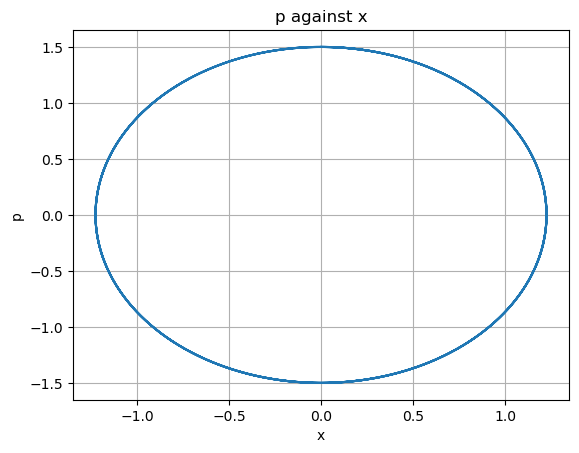

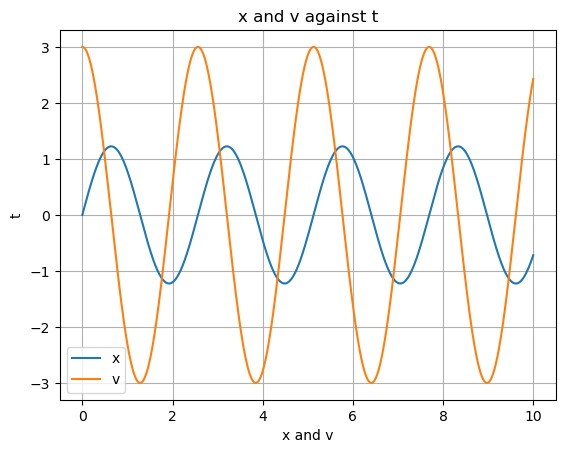

In [60]:
# Global variables
global r, omega, error_m, omega_f, F0, h_interpolate, noisiness

# Input parameters
m = 0.5  # Mass of the mirror
k = 3.0  # Spring constant
gamma = 0.0  # Damping coefficient
noisiness = 0

# Derived parameters
r = gamma / (2 * m)  # Damping ratio
omega = (k / m) ** 0.5  # Natural frequency

# Initial conditions
x0 = 0.0  # Initial position
v0 = 3.0  # Initial velocity
t0 = 0.0  # Start time
tf = 10.0  # End time
h = 0.1  # Initial step size
h_interpolate = 0.01
S0 = np.array([x0, v0])  # Initial state vector
error_m = 1e-6  # Tolerance for error
F0 = 0  # Driving force amplitude
omega_f = np.sqrt(6)  # Driving frequency

# Solving the ODE using RK45 method
t_values, x_values, noise_iso = RK45(f, t0, tf, S0, h)  # Solve the differential equations
p_values = m * x_values[:, 1]

plt.plot(x_values[:, 0], p_values)  # Plot phase space
plt.xlabel('x')
plt.ylabel('p')  # Y-axis label
plt.title('p against x')  # Plot title
plt.grid(True)  # Show grid
plt.show()

plt.plot(t_values, x_values[:, 0], label = 'x')
plt.plot(t_values, x_values[:, 1], label = 'v')
plt.xlabel('x and v')  # X-axis label
plt.ylabel('t')  # Y-axis label
plt.title('x and v against t')  # Plot title
plt.legend()
plt.grid(True)  # Show grid
plt.show()

### Damped, Undriven, Non-noisy Harmonic Oscillator

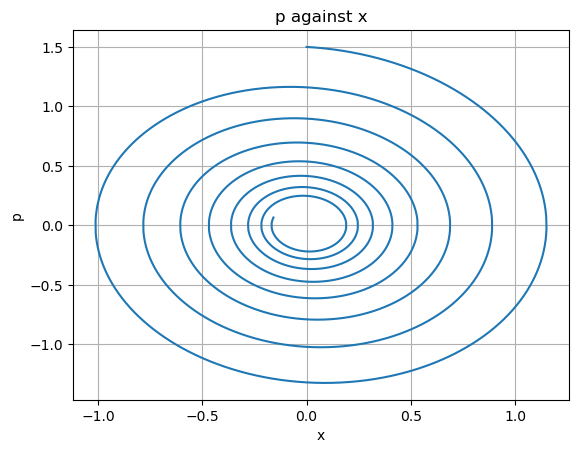

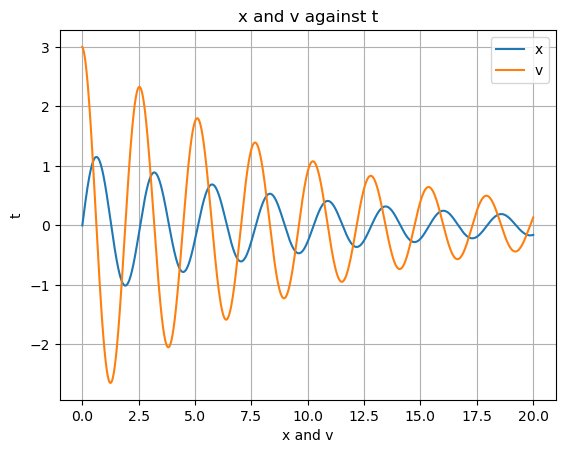

In [115]:
m = 0.5  # Mass of the mirror
k = 3.0  # Spring constant
gamma = 0.1  # Damping coefficient

# Derived parameters
r = gamma / (2 * m)  # Damping ratio
omega = (k / m) ** 0.5  # Natural frequency
noisiness = 0

# Initial conditions
x0 = 0.0  # Initial position
v0 = 3.0  # Initial velocity
t0 = 0.0  # Start time
tf = 20.0  # End time
h = 0.1  # Initial step size
h_interpolate = 0.01
S0 = np.array([x0, v0])  # Initial state vector
error_m = 1e-6  # Tolerance for error
F0 = 0  # Driving force amplitude
omega_f = np.sqrt(6)  # Driving frequency

# Solving the ODE using RK45 method
t_values, x_values, noise_iso = RK45(f, t0, tf, S0, h)  # Solve the differential equations
p_values = m * x_values[:, 1]

plt.plot(x_values[:, 0], p_values)  # Plot phase space
plt.xlabel('x')  # X-axis label
plt.ylabel('p')  # Y-axis label
plt.title('p against x')  # Plot title
plt.grid(True)  # Show grid
plt.show()

plt.plot(t_values, x_values[:, 0], label = 'x')
plt.plot(t_values, x_values[:, 1], label = 'v')
plt.xlabel('t')  # X-axis label
plt.ylabel('x and v')  # Y-axis label
plt.title('x and v against t')  # Plot title
plt.legend()
plt.grid(True)  # Show grid
plt.show()

### Damped, Undriven, Noisy Harmonic Oscillator

[-22.69511605  11.58486336   6.43527255 ...   2.54079125  21.43255759
   2.76449954]


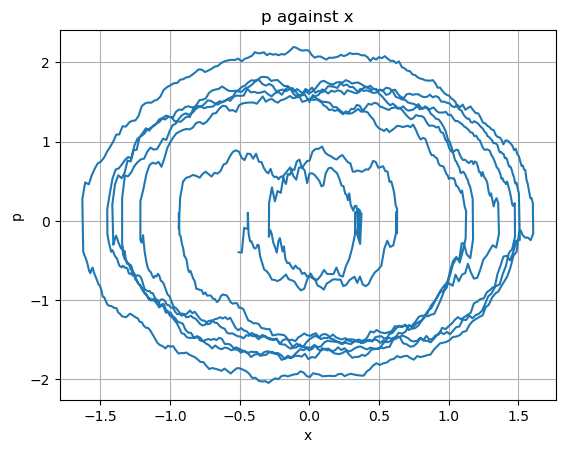

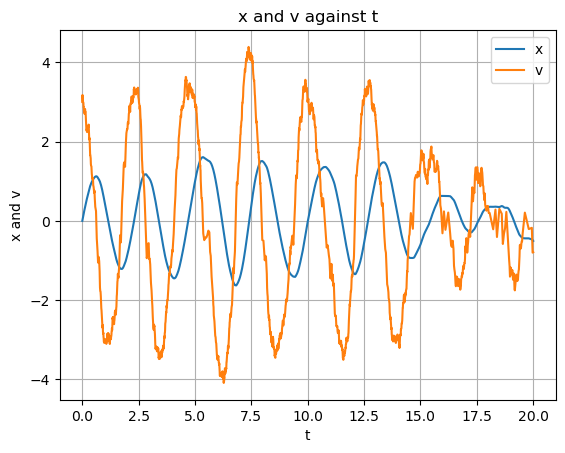

In [192]:
m = 0.5  # Mass of the mirror
k = 3.0  # Spring constant
gamma = 0.1  # Damping coefficient

# Derived parameters
r = gamma / (2 * m)  # Damping ratio
omega = (k / m) ** 0.5  # Natural frequency
noisiness = 8.00

# Initial conditions
x0 = 0.0  # Initial position
v0 = 3.0  # Initial velocity
t0 = 0.0  # Start time
tf = 20.0  # End time
h = 0.1  # Initial step size
T = 297
h_interpolate = 0.01
S0 = np.array([x0, v0])  # Initial state vector
error_m = 1e-5  # Tolerance for error
F0 = 0  # Driving force amplitude
omega_f = np.sqrt(6)  # Driving frequency

# Solving the ODE using RK45 method
t_values, x_values, noise_iso = RK45(f, t0, tf, S0, h)  # Solve the differential equations
noise_iso = noisiness * noise_iso
p_values = m * x_values[:, 1]
print(noise_iso)

plt.plot(x_values[:, 0], p_values)  # Plot phase space
plt.xlabel('x')  # X-axis label
plt.ylabel('p')  # Y-axis label
plt.title('p against x')  # Plot title
plt.grid(True)  # Show grid
plt.show()

plt.plot(t_values, x_values[:, 0], label = 'x')
plt.plot(t_values, x_values[:, 1], label = 'v')
plt.xlabel('t')  # X-axis label
plt.ylabel('x and v')  # Y-axis label
plt.title('x and v against t')  # Plot title
plt.legend()
plt.grid(True)  # Show grid
plt.show()

### Noise Correlation